<font size="5">Exploratory Data Analysis</font>  

Google Covid-19 Data

Author: Nicholas

The purpose of this notebook is 

1. Get a function to come out with a covid severity graph per country/subregion
2. Get a table of the distribution of areas of each country, reason: so that I know what the limitations of my analysis is when I attempt to aggregate the country's response in a large country like the USA.
3. Clustering countries by similarity (at least show one example)
4. Compare govt. reponse

The four data sets I have been assigned are:
1. Demographics
2. Economy
3. Epidemiology
4. Emergency Declarations

# Load Packages


In [1]:
# Run this cell to set up your notebook
import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model

import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure


import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
#import cufflinks as cf


%matplotlib inline
sns.set()
sns.set_context("talk")

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import plotly.express as px

# Code to install package
# import sys
# !{sys.executable} -m pip install tslearn

# Load and Inspect Datasets

## Read CSV

In [2]:
index = pd.read_csv (r'datasets\index.csv')
gov_res = pd.read_csv(r'datasets\government-response.csv')
epid = pd.read_csv(r'datasets\epidemiology.csv')
demo = pd.read_csv (r'datasets\demographics.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets\\epidemiology.csv'

## `index`: country-level

In [ ]:
index_country_level = index[['location_key','country_code','country_name']]
index_country_level.head(2)

## `country_level` function

In [ ]:
# country_level preserves the row of the df
# the only thing it does is append the country _code so that you can 
# filter by country_code/name
# which you cannot do with just the location_key
def country_level(df):
    return index_country_level.merge(df)

## `gov_res`: country-level

In [ ]:
gov_res

## `epid` : country-level

In [ ]:
epid_country =  country_level(epid)
epid_country.head(2)

## `demo` country-level

In [ ]:
demo_country = country_level(demo)
demo_country.head(2)

# Extract Death Statistic per country

## `demo`

In [ ]:
demo_UK = demo_country[(demo_country["location_key"] == 'GB')].reset_index()
demo_UK.head()

In [ ]:
print("The total population of UK is",demo_UK["population"][0],".")

In [ ]:
demo_country[(demo_country["country_code"] == 'GB')].sort_values('population_urban').head(2)

## `epid`

In [ ]:
# Need to come up with covid severity graph for all of UK aggregated

In [ ]:
# Step 1: Filter by country
epid_UK = epid[(epid["location_key"] == 'GB')]
epid_UK.head(2)

## `epid` by UK by month

In [ ]:

# Step 2: Change `date` column to datetime data type
epid_UK['date'] = pd.to_datetime(epid_UK['date'])
# Step 3: Create a new column with only the months
epid_UK['month_year'] = epid_UK['date'].dt.to_period('M')

# Step 4: Create a new data frame that groups by and sums up the months
epid_UK_month = epid_UK.groupby('month_year').agg('sum')

# Step 5: Change the data type of the index from `datetime` to `string` type.
# This is to aid plotting.
epid_UK_month.index=epid_UK_month.index.to_series().astype(str)
epid_UK_month.head()

In [ ]:
# Step 6: Extract the series new_deceased
# 33 months of info, each country will have an aggregated signal 
# composed of 33 months
len(epid_UK_month['new_deceased'])

### Sample signal for `country == UK`

In [ ]:
epid_UK_month.dtypes
fig = px.line(epid_UK_month, x=epid_UK_month.index, y=epid_UK_month.columns[1])
fig.show()

## `Epid` by another country that's not UK by month

In [ ]:
# goal is to create a function that will give me
# index: month_year
# columns: all the countries and their death rates per month
# step 1: Filter epid by specific country
epid_US = epid[(epid["location_key"] == 'US')]
# step 2: 


In [ ]:
# per month agg statistics
epid_UK.groupby(pd.Grouper(key='date', freq='M'))

## Function

In [ ]:
# Sample function to get column of all the country's deaths by month.

# List of all unique country codes
# for use in function later
unique_countries = index['country_code'].unique()

def new_deceased_month(df, country_name):
    #Step 1: Filter by country
    epid_country1 = epid[(epid["location_key"] == country_name)]
    
    # Step 2: Change `date` column to datetime data type
    epid_country1['date'] = pd.to_datetime(epid_country1['date'])
    
    # Step 3: Create a new column with only the months
    epid_country1['month_year'] = epid_country1['date'].dt.to_period('M')

    # Step 4: Create a new data frame that groups by and sums up the months
    epid_country1_month = epid_country1.groupby('month_year').agg('sum')

    # Step 5: Change the data type of the index from `datetime` to `string` type.
    # This is to aid plotting.
    epid_country1_month.index=epid_country1_month.index.to_series().astype(str)
    
    # Step 6: Change the column name of `new_deceased` to country's name
    epid_country1_month = epid_country1_month[['new_deceased']].reset_index().rename(columns = {'new_deceased':country_name})
    return epid_country1_month

### For-loop

Warning: This for loop takes a long while to run. The output has already been saved as a .csv. 
You can uncommment a run it if you want, but it will take around 15 mins.

In [ ]:
# # Initialise an empty dataframe
# deceased_month = pd.DataFrame({
#     'month_year' : epid_UK_month.index
# })

# for country in unique_countries:
#     country1 = new_deceased_month(epid, country)
#     deceased_month = deceased_month.merge(country1, how = 'left')

# Dynamic Time Warping

## Read `deceased_month`
`deceased_month` is an aggregated dataset that has the sum of deaths per month per month. 
Each row is a month from 2020 to 2022 and each column represents one country. 

In [ ]:
deceased_month = pd.read_csv (r'generated_data\deceased_month.csv')
deceased_month.head()

In [ ]:
# Remove NAs from `deceased_month` 
deceased_month_noNAs = deceased_month.dropna(axis='columns').iloc[:,0:]

# Export dataset as CSV
# Uncomment if you want to save the file again
deceased_month_noNAs.to_csv(r"generated_data\deceased_month_noNAs.csv")

In [ ]:
deceased_month_noNAs

## DTW Algo

In [ ]:
# DTW Matrix Code
# From: https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [ ]:
# Test
x= [1,2,3,4,5,6,7,8,9,10]
y= [1,1,2,3,4,5,6,7,8,9,10]

In [ ]:
np.matrix(dtw(x,y))

In [ ]:
# # Columns with NA Value
# deceased_month.loc[:, deceased_month.isna().any()]
# # deceased_month.isna().any(axis=0)

## DTW Package

In [ ]:
# import sys
# !{sys.executable} -m pip install dtw-python

In [ ]:
import numpy as np
from dtw import *
import matplotlib as plt
import pandas as pd

In [ ]:
## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

## Find the best match with the canonical recursion formula
alignment = dtw(query, template, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")


In [ ]:
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

## SG/TW Comparison

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

plot = dtw(deceased_month['SG'].values,deceased_month['TW'].values, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

plot.set_title("Comparison of Case Fatality in TW and SG")
plot.set_xlabel("Month")
plot.set_ylabel("Death")


In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

plot = dtw(deceased_month['SG'].values,deceased_month['JP'].values, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

plot.set_title("Comparison of Case Fatality in JP and SG")
plot.set_xlabel("Month")
plot.set_ylabel("Death")


## Heatmap of DTW values

In [ ]:
# import sys
# !{sys.executable} -m pip install fastdtw

In [ ]:
from fastdtw import fastdtw

In [ ]:
deceased_month_noNAs.head(5)

In [ ]:
countries_noNAs = deceased_month_noNAs.columns[1:].array
countries_noNAs

In [ ]:
# Use this code to get pairwise dtw cost
print("The difference between SG and TW is",fastdtw(df['SG'].values,df['TW'].values)[0],".")
print("The difference between SG and JP is",fastdtw(df['SG'].values,df['JP'].values)[0],".")
print("The difference between SG and US is",fastdtw(df['SG'].values,df['US'].values)[0],".")

In [ ]:
# Create pandas dataframe for pairwise comparisons between the countries
df_dtw_pairwise = pd.DataFrame(index = df.columns, columns = df.columns)
df_dtw_pairwise = df_dtw_pairwise.drop("month_year")
df_dtw_pairwise = df_dtw_pairwise.drop("month_year", axis = 1)

df_dtw_pairwise.head()

In [ ]:
# Uncomment if you want to rerun this for-loop

# for row_index, i in enumerate(countries_noNAs):
#     for column_index, j in enumerate(countries_noNAs):
#         df_dtw_pairwise.iloc[row_index, column_index] = fastdtw(df[i].values, df[j].values)[0]

In [ ]:
df_dtw_pairwise.head(30)

In [ ]:
# df_dtw_pairwise.to_csv(r"generated_data\dtw_pairwise.csv")

In [ ]:
df_dtw_pairwise = pd.read_csv(r"generated_data\dtw_pairwise.csv")
df_dtw_pairwise = df_dtw_pairwise.set_index("Unnamed: 0")

df_dtw_pairwise.head(20)

In [ ]:
df_dtw_pairwise.iloc[:21,:21]

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.heatmap(df_dtw_pairwise, cmap = 'coolwarm')
# p.sns.color_palette("coolwarm", as_cmap=True)
p.set( xlabel = "Countries", ylabel = "Countries")


# Time-series Clustering

## Convert DF to Array dtype

At this point in the notebook, we use the `tslearn` package to cluster similar time series based on death.
We need to convert the dataframe to an array for the `tslearn` package to run the clustering algorithm.

In [3]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model

import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline
sns.set()
sns.set_context("talk")

import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff



## Load dataframes

In [4]:
# Load index df
index = pd.read_csv (r'datasets\index.csv')
# Load df of time series
deceased_month_noNAs = pd.read_csv(r"generated_data\deceased_month_noNAs.csv").iloc[:,1:]
# Load matrix of pairwise dtw distance values
df_dtw_pairwise = pd.read_csv(r"generated_data\dtw_pairwise.csv")

In [5]:
index_country_level = index[['location_key','country_code','country_name']]
country_codes = index_country_level.groupby(['country_code','country_name']).agg('count').reset_index().iloc[:,:2]

In [6]:
# Turn `deceased_month_noNAs` into a numpy array
X = deceased_month_noNAs.iloc[:,1:].transpose().to_numpy()

In [7]:
# Load tslearn (timeseries learn package)
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.generators import random_walks

## Inertia Comparison

Initiate a for loop to get inertia values of n-clusters for n between 1 and 100.

In [8]:
################################################
# This loop took my X260 around 30 mins to run.#
################################################
# for i in range(101):
#     if i ==0:
#         pass
#     else:
#         km = TimeSeriesKMeans(n_clusters= i , metric="dtw",
#                        random_state=0, dtw_inertia = True)
#         inertia.append(km.fit(X).inertia_)

#################################################
#Create the inertia dataframe for visualisation.#
#################################################

# inertia_df = pd.DataFrame({
#     'inertia' : inertia,
#     'inertia_log': np.log(inertia)
# }).reset_index()

# inertia_df['index'] = inertia_df['index'] + 1
# inertia_df = inertia_df.rename(columns = {'index':'n_clusters'})
# inertia_df['n_clusters'] = inertia_df['n_clusters'].astype(int)
# inertia_df.to_csv(r"generated_data\inertia_df.csv")

In [9]:
# Read inertia_df
inertia_df = pd.read_csv (r'generated_data\inertia_df.csv').iloc[:,1:]

Text(0, 0.5, 'Log of Inertia Values')

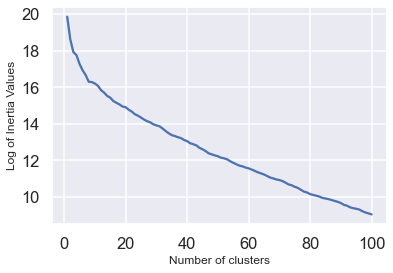

In [10]:
p = sns.lineplot(
    data=inertia_df,
    x="n_clusters", y="inertia_log",
    markers=True, dashes=False
)

p.set_xlabel("Number of clusters", fontsize = 12)
p.set_ylabel("Log of Inertia Values", fontsize = 12)


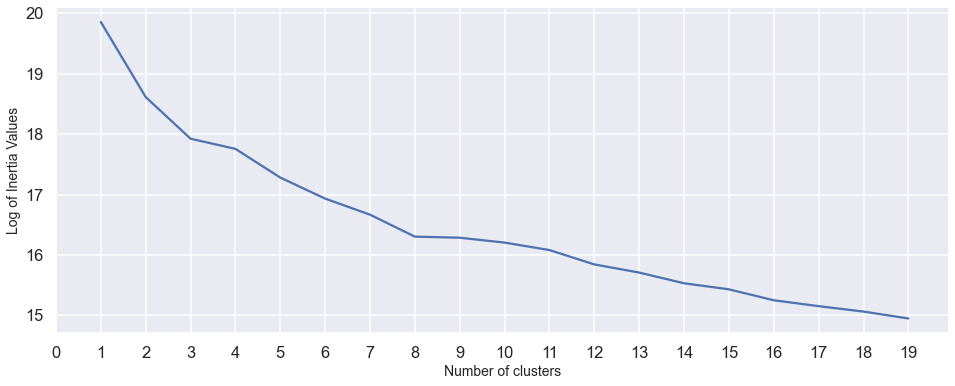

In [11]:
plt.figure(figsize=(16, 6))
p = sns.lineplot(
    data=inertia_df[(inertia_df["n_clusters"] < 20)],
    x="n_clusters", y="inertia_log",
    markers= True, dashes=False,ms=50
)

p.set_xlabel("Number of clusters", fontsize = 14)
p.set_ylabel("Log of Inertia Values", fontsize = 14)
_ = plt.xticks(np.arange(0, 20, step=1))

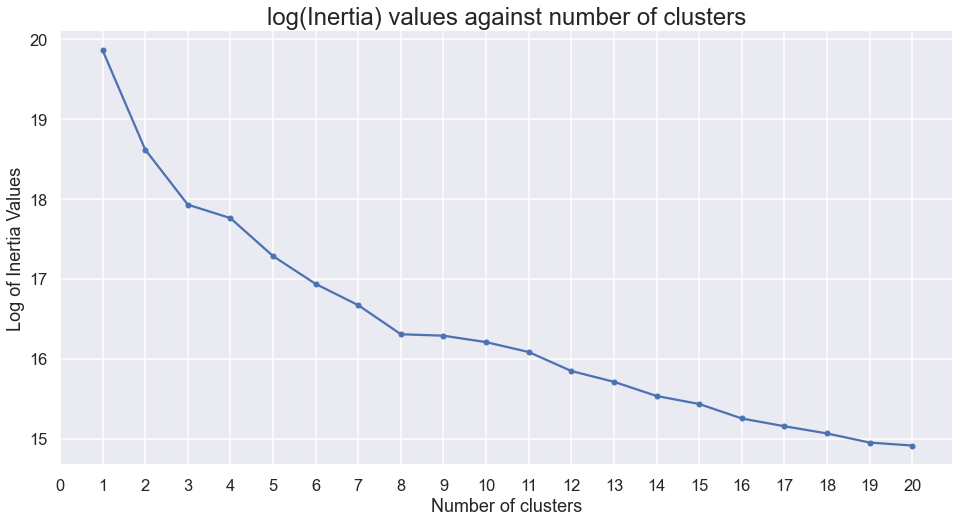

In [12]:
plt.figure(figsize=(16, 8))
plt.plot('n_clusters',"inertia_log", scalex=True, scaley=True, data=inertia_df[(inertia_df["n_clusters"] < 21)],
         marker="o", markersize =5)
plt.xlabel("Number of clusters")
plt.ylabel("Log of Inertia Values")
plt.title("log(Inertia) values against number of clusters", fontsize = 24)
_ = plt.xticks(np.arange(0, 21, step=1))

In [13]:
inertia_df[(inertia_df["n_clusters"] < 41) & (inertia_df["n_clusters"] > 19)]

,n_clusters,inertia,inertia_log
19,20,2.995020e+06,14.912461
20,21,2.611851e+06,14.775570
21,22,2.359935e+06,14.674145
22,23,2.042644e+06,14.529756
23,24,1.888913e+06,14.451512
24,25,1.700290e+06,14.346309
25,26,1.524031e+06,14.236869
26,27,1.394022e+06,14.147704
27,28,1.310103e+06,14.085616
28,29,1.177474e+06,13.978882


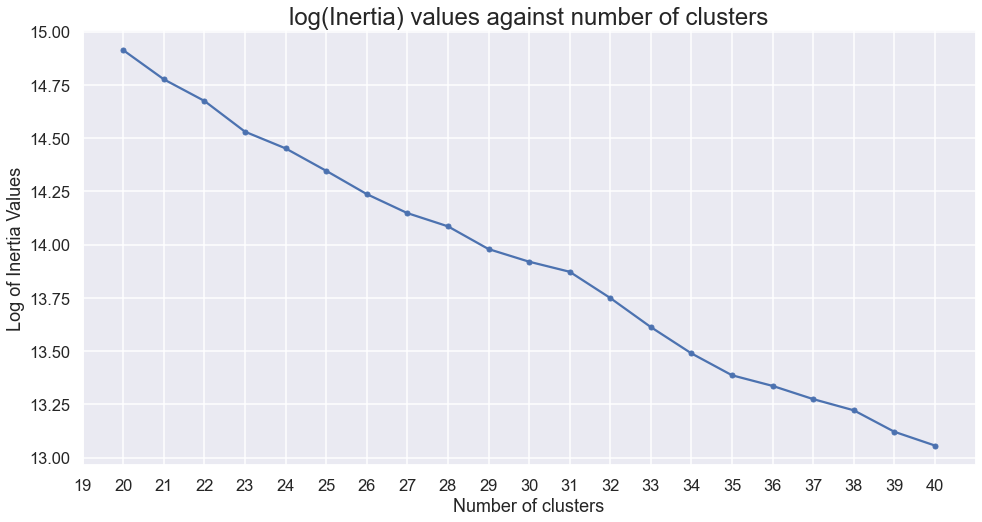

In [14]:
plt.figure(figsize=(16, 8))
plt.plot('n_clusters',"inertia_log", scalex=True, scaley=True, 
         data=inertia_df[(inertia_df["n_clusters"] < 41) & (inertia_df["n_clusters"] > 19)],
         marker="o", markersize =5)
plt.xlabel("Number of clusters")
plt.ylabel("Log of Inertia Values")
plt.title("log(Inertia) values against number of clusters", fontsize = 24)
_ = plt.xticks(np.arange(19, 41, step=1))

## fit_predict (Choose n_clusters = 8)

In [15]:
km = TimeSeriesKMeans(n_clusters= 8 , metric="dtw",
               random_state=0, dtw_inertia = True)
y_pred = km.fit_predict(X)

In [16]:
len(y_pred)

229

In [17]:
cluster_labels = pd.DataFrame({
    'cluster' : y_pred
})

In [18]:
clustered_df = deceased_month_noNAs.iloc[:,1:].transpose()
clustered_df['cluster'] = y_pred + 1
clustered_df = clustered_df.reset_index().rename(columns = {'index':"country_code"})
clustered_df

,country_code,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,cluster
0,AD,0.0,0.0,13.0,30.0,8.0,1.0,0.0,1.0,0.0,...,5.0,6.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2
1,AE,0.0,0.0,8.0,103.0,155.0,50.0,35.0,33.0,37.0,...,83.0,53.0,1.0,0.0,3.0,12.0,18.0,6.0,0.0,2
2,AF,0.0,0.0,4.0,68.0,202.0,537.0,476.0,126.0,49.0,...,61.0,192.0,62.0,12.0,24.0,16.0,28.0,27.0,5.0,2
3,AG,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,8.0,8.0,0.0,2.0,1.0,3.0,3.0,1.0,0.0,2
4,AI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,YE,0.0,0.0,0.0,2.0,82.0,234.0,177.0,76.0,17.0,...,29.0,122.0,8.0,6.0,0.0,0.0,2.0,4.0,0.0,2
225,YT,0.0,0.0,2.0,2.0,20.0,11.0,4.0,1.0,2.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
226,ZA,1.0,0.0,4.0,111.0,704.0,4415.0,5404.0,6110.0,2603.0,...,4090.0,4142.0,612.0,321.0,856.0,592.0,171.0,126.0,0.0,4
227,ZM,3.0,0.0,0.0,2.0,4.0,23.0,134.0,125.0,43.0,...,180.0,32.0,14.0,10.0,11.0,16.0,12.0,1.0,0.0,2


## Distribution of clusters

In [19]:
# Number of countries per cluster
cluster_count = clustered_df.groupby('cluster').agg('count').iloc[:,:1].reset_index().rename(columns = {0:'count'})
cluster_count = cluster_count.rename(columns = {"country_code": 'count'})

## List of countries per cluster

In [20]:
index_country_level = index[['location_key','country_code','country_name']]

In [21]:
cluster_1 = pd.merge(clustered_df[(clustered_df["cluster"] == 1)],country_codes, how = "inner")

In [22]:
cluster_1 = pd.merge(clustered_df[(clustered_df["cluster"] == 1)],country_codes, how = "inner")
cluster_2 = pd.merge(clustered_df[(clustered_df["cluster"] == 2)],country_codes, how = "inner")
cluster_3 = pd.merge(clustered_df[(clustered_df["cluster"] == 3)],country_codes, how = "inner")
cluster_4 = pd.merge(clustered_df[(clustered_df["cluster"] == 4)],country_codes, how = "inner")
cluster_5 = pd.merge(clustered_df[(clustered_df["cluster"] == 5)],country_codes, how = "inner")
cluster_6 = pd.merge(clustered_df[(clustered_df["cluster"] == 6)],country_codes, how = "inner")
cluster_7 = pd.merge(clustered_df[(clustered_df["cluster"] == 7)],country_codes, how = "inner")
cluster_8 = pd.merge(clustered_df[(clustered_df["cluster"] == 8)],country_codes, how = "inner")

In [23]:
cluster_count.sort_values(['count'])

,cluster,count
2,3,1
4,5,1
5,6,1
0,1,2
7,8,2
3,4,11
6,7,33
1,2,178


We see that cluster 3,5,6 are single outliers, have 1 country in each cluster.
We see that cluster 1,8 are also outliers, have 2 countries in each cluster. 

In [24]:
cluster_3['country_name']

0    Brazil
Name: country_name, dtype: object


<font size="6">Single Country Outliers </font>

In [25]:
print("Cluster 3:", *cluster_3['country_name'])
print("Cluster 5:", *cluster_5['country_name'])
print("Cluster 6:", *cluster_6['country_name'])

Cluster 3: Brazil
Cluster 5: United States of America
Cluster 6: India


<font size="6">Dual Country Outliers </font>

In [26]:
print("Cluster 1:", *cluster_1['country_name'], sep = "\n")
print("\n")
print("Cluster 8:", *cluster_8['country_name'], sep = "\n")

Cluster 1:
Mexico
Russia


Cluster 8:
United Kingdom
Indonesia


<font size="6"> Cluster 4: 11 Countries </font>

In [27]:
print("Cluster 4:", *cluster_4['country_name'], sep = "\n")

Cluster 4:
Argentina
Colombia
Germany
Spain
France
Iran
Italy
Peru
Poland
Ukraine
South Africa


<font size="6"> Cluster 7: 33 Countries </font>

In [28]:
print("Cluster 7:", *cluster_7['country_name'], sep = "\n")

Cluster 7:
Austria
Bangladesh
Belgium
Bulgaria
Bolivia
Canada
Chile
China
Czech Republic
Ecuador
Greece
Hungary
Iraq
Japan
South Korea
Kazakhstan
Sri Lanka
Myanmar
Malaysia
Netherlands
Nepal
Philippines
Pakistan
Portugal
Paraguay
Romania
Sweden
Slovakia
Thailand
Tunisia
Turkey
Taiwan
Vietnam


<font size="6"> Cluster 2: 128 Countries </font>

In [29]:
print("Cluster 2:", *cluster_2['country_name'], sep = "\n")

Cluster 2:
Andorra
United Arab Emirates
Afghanistan
Antigua and Barbuda
Anguilla
Albania
Armenia
Angola
American Samoa
Australia
Aruba
Azerbaijan
Bosnia and Herzegovina
Barbados
Burkina Faso
Bahrain
Burundi
Benin
Bermuda
Brunei
Bahamas
Bhutan
Botswana
Belarus
Belize
Democratic Republic of the Congo
Central African Republic
Republic of the Congo
Switzerland
Ivory Coast
Cook Islands
Cameroon
Costa Rica
Cuba
Cape Verde
Curaçao
Cyprus
Djibouti
Denmark
Dominica
Dominican Republic
Algeria
Estonia
Egypt
Eritrea
Ethiopia
Finland
Fiji
Falkland Islands
Micronesia
Faroe Islands
Gabon
Grenada
Georgia
French Guiana
Guernsey
Ghana
Gibraltar
Greenland
Gambia
Guinea
Equatorial Guinea
Guatemala
Guam
Guinea-Bissau
Guyana
Honduras
Croatia
Haiti
Ireland
Israel
Isle of Man
Iceland
Jersey
Jamaica
Jordan
Kenya
Kyrgyzstan
Cambodia
Kiribati
Comoros
Saint Kitts and Nevis
North Korea
Kuwait
Cayman Islands
Laos
Lebanon
Saint Lucia
Liechtenstein
Liberia
Lesotho
Lithuania
Luxembourg
Latvia
Libya
Morocco
Monaco
Mold